# Evaluation

## Introduction

In this notebook, we aim to evaluate the performance of the underlying semantic search algorithm, ANN.

Evaluation of retrieval usually involves comparing the results of a search algorithm with a set of ground-truth queries. The ground-truth queries are usually manually annotated by human experts and are considered to be the most relevant results for a given query.

In our case, because our data source is novel and unique, we do not have ground-truth queries.

Instead, we will generate synthetic queries using a language model and evaluate the performance of the retrieval algorithm based on these queries.

## Goals

- Generate synthetic queries for a sampled subset of text chunks using an LLM.
- Embed both the text chunks and the queries using Cohere embeddings.
- Implement retrieval systems using both Annoy (Approximate Nearest Neighbors) and brute-force KNN search.
- Evaluate and compare the performance of both retrieval methods using metrics such as Precision@K, Recall@K, Mean Reciprocal Rank (MRR), and Normalized Discounted Cumulative Gain (NDCG).
- Analyze the results to understand the trade-offs between accuracy and efficiency in approximate and exact search methods.

## Technical Details

- Embedding model: Cohere's `embed-multilingual-v3.0`.
- Query generation model: Anthropic's `claude-3-5-sonnet`.
- ANN Vector DB: Spotify's `Annoy`.

## 1. Imports and setup

- We import required libraries and set up API credentials.
- We load the data from an existing dataframe saved as a parquet file.
- This dataframe already contains the text embeddings for each text chunk.

In [12]:
import os
import json
import cohere
import anthropic
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score, recall_score, precision_score
from annoy import AnnoyIndex


from dotenv import load_dotenv

load_dotenv()

cohere_api_key = os.getenv('COHERE_PROD')
anthropic_api_key = os.getenv('ANTHROPIC')
co = cohere.Client(api_key=cohere_api_key, log_warning_experimental_features=False)
anth = anthropic.Anthropic(api_key=anthropic_api_key)

In [9]:
df = pd.read_parquet('../data/backups/df_chunks_clust.parquet')

In [10]:
df

,text,start_index,end_index,token_count,page,volume,author,book,embeddings,cluster,is_representative,cluster_topic
0,بسم الله الرحمن الرحيم أحمد الله أولا حمدا كثي...,0,1535,500,P001,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.02581787109375, 0.06256103515625, -0.007503...",2,False,Wisdom
1,في الأسفار فاقتصرت فيه على ذكر طرف الحديث وصحا...,1214,2792,500,P001,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.03253173828125, 0.07135009765625, -0.020233...",2,False,Wisdom
2,العلم طمعا في نيل ما تعبده الله تعالى به من تز...,2490,4034,498,P001,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.00664520263671875, 0.049041748046875, -0.03...",2,True,Wisdom
3,وشبكة للحطام فأما علم طريق الآخرة وما درج عليه...,3745,5359,499,P002,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.0269012451171875, 0.056640625, -0.026824951...",2,False,Wisdom
4,الكسب وكتاب الحلال والحرام وكتاب آداب الصحبة و...,5050,6653,499,P002,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.020660400390625, 0.05975341796875, -0.02926...",0,False,Spirituality
...,...,...,...,...,...,...,...,...,...,...,...,...
3973,منها كما تخرج الحبة فى حميل السيل ألا ترونها ت...,5127397,5129086,500,P545,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.006313323974609375, 0.068603515625, -0.0333...",3,False,Faith
3974,صلى الله عليه وسلم فقال هم الذين لا يكتوون ولا...,5128730,5130355,499,P546,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.01000213623046875, 0.06353759765625, -0.032...",3,False,Faith
3975,فأعطانى هكذا وفرج عبد الله بن أبى بكر بين يديه...,5130037,5131693,500,P546,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.03472900390625, 0.058441162109375, -0.03292...",3,False,Faith
3976,مكانه النار يهوديا أو نصرانيا فاستحلفه عمر بن ...,5131347,5133042,498,P546,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.044952392578125, 0.06646728515625, -0.04867...",5,False,Afterlife


## 2. Generate sample

- We calculate sample size using the standard sample size formula.
- Resulting sample size for 95% confidence level and 5% margin of error is 350~.
- Each sample retains the original index of the text chunk.

In [35]:
np.random.seed(42)

sample_size = 350
sampled_df = df.sample(n=sample_size)

sampled_df

,text,start_index,end_index,token_count,page,volume,author,book,embeddings,cluster,is_representative,cluster_topic
408,المفصل إلى ثلاثين آية وفي العصر بنصف ذلك وفي ا...,537322,539052,500,P176,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.000274658203125, 0.0307159423828125, -0.009...",4,False,Rituals
2307,الآخرة بالفكر والذكر الذي هو أعلى مقامات السال...,2994255,2995873,498,P236,V03,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.01207733154296875, 0.053558349609375, -0.01...",8,True,Gratitude
682,الحب وقوله عز وجل إذا لأذقناك ضعف الحياة وضعف ...,893583,895136,499,P291,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.005924224853515625, 0.055572509765625, -0.0...",3,False,Faith
3156,حالة هي أعلى من الزهد وهي أن يستوي عنده وجود ا...,4083813,4085474,500,P190,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[-0.0004267692565917969, 0.0506591796875, -0.0...",8,False,Gratitude
2355,على كسرة وملح فوالله ما زادني عليهما بيان الإي...,3055450,3057049,499,P256,V03,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.01531219482421875, 0.050750732421875, -0.01...",9,False,Discipline
...,...,...,...,...,...,...,...,...,...,...,...,...
3253,جبة صوف من صوف أنمار الحديث رواه أبو داود الطي...,4210010,4211572,500,P232,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.009796142578125, 0.054931640625, -0.0237274...",6,False,Virtue
2770,تعالى الله عن قوله علوا كبيرا وكذلك في قوله صل...,3587744,3589398,500,P023,V04,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.0177459716796875, 0.052032470703125, -0.048...",1,False,Theology
56,ذلك من علوم الآخرة وقيل للشافعي رحمه الله متى ...,75370,77016,499,P025,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[0.0157928466796875, 0.049652099609375, 0.0033...",2,False,Wisdom
829,له أن يضيع العيال ويستغرق الأوقات في العبادات ...,1086137,1087843,500,P349,V01,محمد بن محمد الغزالي أبو حامد,إحياء علوم الدين,"[-0.015716552734375, 0.0228729248046875, 0.013...",8,False,Gratitude


## 3. Generate queries

- Since we do not have ground-truth queries, we generate synthetic queries using a language model.
- We use Anthropic's `claude-3-5-sonnet` model to generate queries for the sampled text chunks.
- We generate 5 queries for each text chunk.
- We save the queries and original indices in a dataframe.

In [36]:
def generate_queries(chunk):

    prompt = f"""Given a section of text in Arabic, your task is to generate 5 hypothetical queries in English. These queries should be:
    1. Relevant to the main themes, concepts, or information presented in the text.
    2. Formulated as if written by someone who has NOT read the text.
    3. General enough that they could be asked about the broader subject, not specific to this particular text.
    4. Varied in their type (e.g., asking about facts, concepts, reasons, comparisons, or implications).
    5. Concise, short and focused.

    Importantly:
    - Do NOT refer to "the text" or "the passage" in your queries.
    - Do NOT use phrases like "according to the text" or "mentioned in the passage".
    - Imagine these are queries a curious person might ask about the general topic, without knowing this specific text exists.

    Text: {chunk}

    Generate 5 queries based on these instructions and format your response as a JSON object using the following format:

    {{
        "q1": "query 1 here.",
        "q2": "query 2 here.",
        "q3": "query 3 here.",
        "q4": "query 4 here.",
        "q5": "query 5 here."
    }}
    
    """

    response = anth.messages.create(
        model="claude-3-5-sonnet-20240620",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=8000,
    )

    return response

In [37]:
response = generate_queries(sampled_df.iloc[0]['text'])

In [38]:
json.loads(response.content[0].text)

{'q1': 'What are the recommended practices for prayer length in Islam?',
 'q2': 'How did Prophet Muhammad perform his last prayer?',
 'q3': 'What guidance is given to imams regarding leading congregational prayers?',
 'q4': 'How many times should one recite tasbeeh during bowing and prostration?',
 'q5': 'What are the differences between praying alone and leading a congregation?'}

In [ ]:
queries = []
chunk_indices = []

for idx, row in tqdm(sampled_df.iterrows(), total=sampled_df.shape[0]):
    chunk_text = row['text']
    
    try:
        response = generate_queries(chunk_text)
    except Exception as e:
        print(f"API request failed for UUID: {idx}, Error: {e}")
        continue

    try:
        questions = json.loads(response.content[0].text)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON for UUID: {idx}, Error: {e}")
        continue

    print(f'UUID: {idx}, Generated {len(questions.keys())} questions')


    for q_key in ['q1', 'q2', 'q3', 'q4', 'q5']:
        queries.append({'question': questions[q_key], 'id': idx})

queries_df = pd.DataFrame(queries)

queries_df.rename(columns={'uuid': 'chunk_index'}, inplace=True)

print(queries_df.head())

In [41]:
queries_df

,question,id
0,What are the recommended practices for leading...,408
1,How did Prophet Muhammad perform his prayers a...,408
2,"What is the importance of brevity in prayer, e...",408
3,How many times should one recite praise during...,408
4,What Surahs are considered appropriate for rec...,408
...,...,...
1555,What are the different levels of purity in Isl...,291
1556,How does Islamic law categorize various substa...,291
1557,Why are certain animals considered impure in s...,291
1558,What role does intention play in determining t...,291


In [42]:
queries_df.to_parquet('../data/backups/queries_df.parquet', index=False)

## 4. Embedding Queries

- We embed the queries using Cohere's `embed-multilingual-v3.0` model.
- The `input_type` is set to `search_query`, which is optimized for search queries.

In [44]:
query_texts = queries_df['question'].tolist()

batch_size = 90
query_embeddings = []

for i in tqdm(range(0, len(query_texts), batch_size)):
    batch_queries = query_texts[i:i+batch_size]
    response = co.embed(
        texts=batch_queries,
        input_type="search_query",
        model="embed-multilingual-v3.0",
    )
    embeddings = response.embeddings
    query_embeddings.extend(embeddings)

query_embeddings = np.array(query_embeddings)

queries_df['embedding'] = query_embeddings.tolist()


  0%|          | 0/18 [00:00<?, ?it/s]

/home/amin/.pyenv/versions/finalproject/lib/python3.12/site-packages/pydantic/_internal/_model_construction.py:268: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warnings.warn(
100%|██████████| 18/18 [00:28<00:00,  1.61s/it]


In [45]:
queries_df

,question,id,embedding
0,What are the recommended practices for leading...,408,"[0.020706177, 0.052337646, 0.008453369, 0.0227..."
1,How did Prophet Muhammad perform his prayers a...,408,"[0.014160156, 0.037200928, -0.014602661, 0.024..."
2,"What is the importance of brevity in prayer, e...",408,"[0.0345459, 0.06939697, 0.022491455, 0.0715332..."
3,How many times should one recite praise during...,408,"[0.01436615, 0.029281616, -0.012863159, 0.0514..."
4,What Surahs are considered appropriate for rec...,408,"[-0.0047340393, 0.043640137, -0.010795593, -0...."
...,...,...,...
1555,What are the different levels of purity in Isl...,291,"[0.03869629, 0.06329346, -0.05178833, 0.059967..."
1556,How does Islamic law categorize various substa...,291,"[-0.0024414062, 0.037139893, -0.012886047, 0.0..."
1557,Why are certain animals considered impure in s...,291,"[0.035491943, 0.06298828, -0.022094727, 0.0512..."
1558,What role does intention play in determining t...,291,"[0.012138367, 0.0569458, -0.008270264, 0.00240..."


## 5. Build the Annoy index

- We build an Annoy index using the original chunk text embeddings.
- `n_trees` is set to 10 for better performance.
- In the Weaviate implementation, the number of trees is set dynamically based on the number of chunks.
- Metric is chosen as `angular` for cosine similarity. It is implemented by using the dot product of normalized vectors.

In [55]:
embedding_dim = len(df['embeddings'].iloc[0])

annoy_index = AnnoyIndex(embedding_dim, 'angular')

for chunk_index, row in tqdm(df.iterrows(), total=len(df)):
    embedding = row['embeddings']
    annoy_index.add_item(chunk_index, embedding)
    
n_trees = 10
annoy_index.build(n_trees)


100%|██████████| 3978/3978 [00:00<00:00, 6005.17it/s]


True

## 6. Define evaluation metrics

- Precision at K (P@K): The proportion of relevant documents in the top K retrieved documents.
- Recall at K (R@K): The proportion of relevant documents that are retrieved out of the total number of relevant documents.
- Mean Reciprocal Rank (MRR): The average of the reciprocal ranks of the first relevant document.
- Normalized Discounted Cumulative Gain (NDCG): A measure of ranking quality that considers the position of a relevant document in the ranked list.

In [57]:
def precision_at_k(relevant, retrieved, k):
    retrieved_at_k = retrieved[:k]
    relevant_set = set(relevant)
    precision = len(set(retrieved_at_k) & relevant_set) / k
    return precision

def recall_at_k(relevant, retrieved, k):
    retrieved_at_k = retrieved[:k]
    relevant_set = set(relevant)
    recall = len(set(retrieved_at_k) & relevant_set) / len(relevant)
    return recall

def mean_reciprocal_rank(relevant, retrieved):
    for rank, item in enumerate(retrieved, start=1):
        if item in relevant:
            return 1 / rank
    return 0


## 7. Evaluate the retrieval system

- We evaluate the retrieval system using the generated queries.
- We run the evaluation per K values.
- We compare the performance of the Annoy index with brute-force KNN search.
- We calculate the evaluation metrics for both methods.
- We analyze the results to understand the trade-offs between accuracy and efficiency in approximate and exact search methods.
- We visualize the evaluation metrics to compare the performance of the two methods.

In [72]:
chunk_embeddings = np.vstack(df['embeddings'].values)
chunk_embeddings_norm = chunk_embeddings / np.linalg.norm(chunk_embeddings, axis=1, keepdims=True)

K_values = [5, 10, 20, 50,100]

precision_scores_annoy = {k: [] for k in K_values}
recall_scores_annoy = {k: [] for k in K_values}
mrr_scores_annoy = []
ndcg_scores_annoy = {k: [] for k in K_values}

precision_scores_brute = {k: [] for k in K_values}
recall_scores_brute = {k: [] for k in K_values}
mrr_scores_brute = []
ndcg_scores_brute = {k: [] for k in K_values}

for idx, row in tqdm(queries_df.iterrows(), total=queries_df.shape[0]):
    query_embedding = np.array(row['embedding'])
    true_chunk_index = row['id']
    
    query_embedding_norm = query_embedding / np.linalg.norm(query_embedding)
    
    similarities = np.dot(chunk_embeddings_norm, query_embedding_norm)
    brute_top_k_indices = np.argsort(-similarities)[:max(K_values)]
    
    annoy_top_k_indices = annoy_index.get_nns_by_vector(
        query_embedding, n=max(K_values), include_distances=False
    )
    
    relevant = [true_chunk_index]
    
    mrr_brute = mean_reciprocal_rank(relevant, brute_top_k_indices)
    mrr_scores_brute.append(mrr_brute)
    
    mrr_annoy = mean_reciprocal_rank(relevant, annoy_top_k_indices)
    mrr_scores_annoy.append(mrr_annoy)
    
    for k in K_values:
        retrieved_brute = brute_top_k_indices[:k]
        precision_brute = precision_at_k(relevant, retrieved_brute, k)
        recall_brute = recall_at_k(relevant, retrieved_brute, k)
        precision_scores_brute[k].append(precision_brute)
        recall_scores_brute[k].append(recall_brute)
        
        relevance_scores_brute = [1 if idx == true_chunk_index else 0 for idx in retrieved_brute]
        ideal_relevance = [1] + [0]*(k-1)
        ndcg_brute = ndcg_score([ideal_relevance], [relevance_scores_brute], k=k)
        ndcg_scores_brute[k].append(ndcg_brute)
        
        retrieved_annoy = annoy_top_k_indices[:k]
        precision_annoy = precision_at_k(relevant, retrieved_annoy, k)
        recall_annoy = recall_at_k(relevant, retrieved_annoy, k)
        precision_scores_annoy[k].append(precision_annoy)
        recall_scores_annoy[k].append(recall_annoy)
        
        relevance_scores_annoy = [1 if idx == true_chunk_index else 0 for idx in retrieved_annoy]
        ndcg_annoy = ndcg_score([ideal_relevance], [relevance_scores_annoy], k=k)
        ndcg_scores_annoy[k].append(ndcg_annoy)


100%|██████████| 1560/1560 [00:20<00:00, 77.03it/s]


In [73]:
average_mrr_brute = np.mean(mrr_scores_brute)
average_mrr_annoy = np.mean(mrr_scores_annoy)

average_precision_brute = {k: np.mean(precision_scores_brute[k]) for k in K_values}
average_recall_brute = {k: np.mean(recall_scores_brute[k]) for k in K_values}
average_ndcg_brute = {k: np.mean(ndcg_scores_brute[k]) for k in K_values}

average_precision_annoy = {k: np.mean(precision_scores_annoy[k]) for k in K_values}
average_recall_annoy = {k: np.mean(recall_scores_annoy[k]) for k in K_values}
average_ndcg_annoy = {k: np.mean(ndcg_scores_annoy[k]) for k in K_values}

print("Mean Reciprocal Rank (MRR):")
print(f"Brute-force MRR: {average_mrr_brute:.4f}")
print(f"Annoy MRR: {average_mrr_annoy:.4f}\n")

print("Average Precision@K:")
for k in K_values:
    print(f"Precision@{k} - Brute-force: {average_precision_brute[k]:.4f}, Annoy: {average_precision_annoy[k]:.4f}")

print("\nAverage Recall@K:")
for k in K_values:
    print(f"Recall@{k} - Brute-force: {average_recall_brute[k]:.4f}, Annoy: {average_recall_annoy[k]:.4f}")

print("\nAverage NDCG@K:")
for k in K_values:
    print(f"NDCG@{k} - Brute-force: {average_ndcg_brute[k]:.4f}, Annoy: {average_ndcg_annoy[k]:.4f}")


Mean Reciprocal Rank (MRR):
Brute-force MRR: 0.1710
Annoy MRR: 0.1523

Average Precision@K:
Precision@5 - Brute-force: 0.0468, Annoy: 0.0433
Precision@10 - Brute-force: 0.0328, Annoy: 0.0285
Precision@20 - Brute-force: 0.0211, Annoy: 0.0184
Precision@50 - Brute-force: 0.0110, Annoy: 0.0094
Precision@100 - Brute-force: 0.0066, Annoy: 0.0054

Average Recall@K:
Recall@5 - Brute-force: 0.2340, Annoy: 0.2167
Recall@10 - Brute-force: 0.3282, Annoy: 0.2853
Recall@20 - Brute-force: 0.4218, Annoy: 0.3686
Recall@50 - Brute-force: 0.5487, Annoy: 0.4699
Recall@100 - Brute-force: 0.6558, Annoy: 0.5404

Average NDCG@K:
NDCG@5 - Brute-force: 0.6167, Annoy: 0.6128
NDCG@10 - Brute-force: 0.4947, Annoy: 0.4907
NDCG@20 - Brute-force: 0.4054, Annoy: 0.3998
NDCG@50 - Brute-force: 0.3249, Annoy: 0.3178
NDCG@100 - Brute-force: 0.2835, Annoy: 0.2757


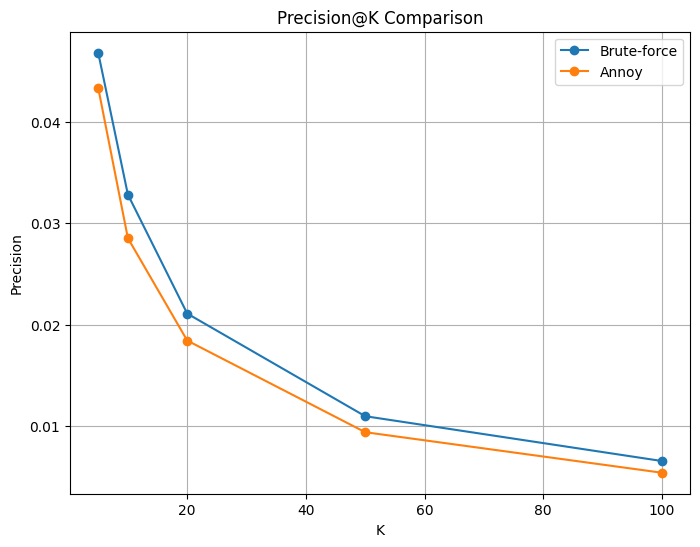

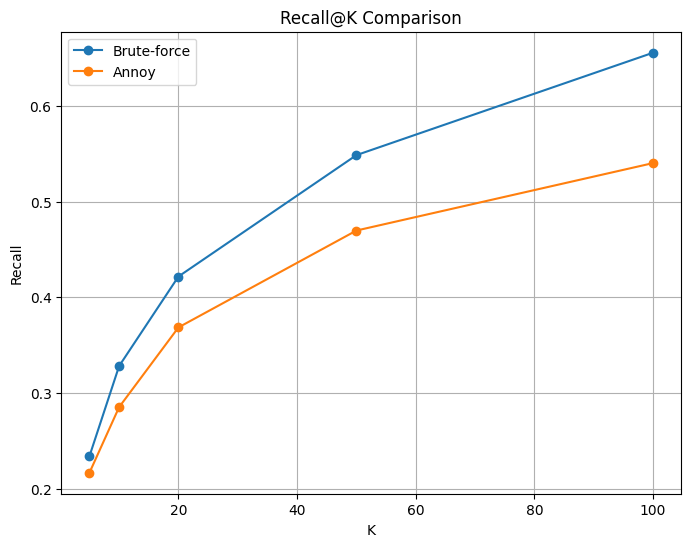

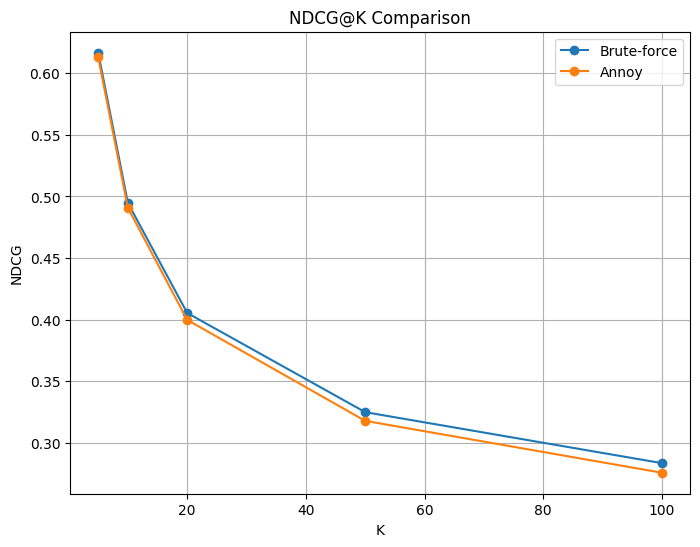

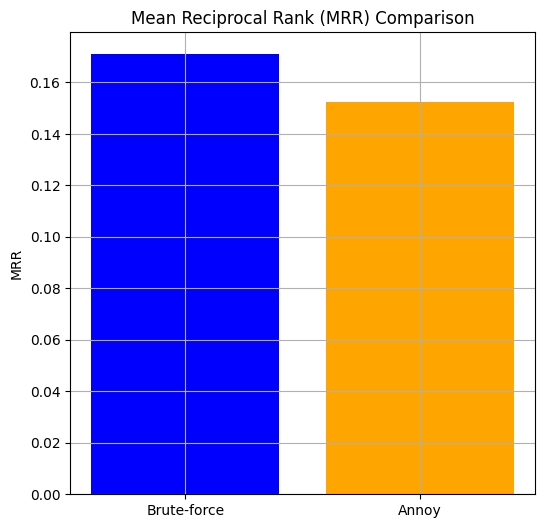

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(K_values, [average_precision_brute[k] for k in K_values], marker='o', label='Brute-force')
plt.plot(K_values, [average_precision_annoy[k] for k in K_values], marker='o', label='Annoy')
plt.title('Precision@K Comparison')
plt.xlabel('K')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(K_values, [average_recall_brute[k] for k in K_values], marker='o', label='Brute-force')
plt.plot(K_values, [average_recall_annoy[k] for k in K_values], marker='o', label='Annoy')
plt.title('Recall@K Comparison')
plt.xlabel('K')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(K_values, [average_ndcg_brute[k] for k in K_values], marker='o', label='Brute-force')
plt.plot(K_values, [average_ndcg_annoy[k] for k in K_values], marker='o', label='Annoy')
plt.title('NDCG@K Comparison')
plt.xlabel('K')
plt.ylabel('NDCG')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.bar(['Brute-force', 'Annoy'], [average_mrr_brute, average_mrr_annoy], color=['blue', 'orange'])
plt.title('Mean Reciprocal Rank (MRR) Comparison')
plt.ylabel('MRR')
plt.grid(True)
plt.show()
